In [1]:
import altair as alt
import os
import pandas as pd
import scipy.io

from simulation_viz.simulation_viz.import_simulation_data import load_simulation, get_time_series_quantiles
from simulation_viz.simulation_viz.check_simulations import check_for_negative_concentrations, get_non_converging_models, remove_models
from simulation_viz.simulation_viz.visualize_simulations import plot_ensemble, plot_model
from simulation_viz.simulation_viz.visualize_simulations_interactive import plot_ensemble_interactive, plot_model_interactive

### Define path to the folder that contains the simulation results and model ensemble

In [2]:
raw_data_dir = '../io/output'

### Define the model name

In [3]:
model_name = 'toy_model'

### Define the simulation name

In [4]:
simulation_name = 'toy_model'

### Define number of models to be simulated

In [5]:
n_models = 5

### Define time points for the data interpolation

Since typically each simulation contains metabolite concentration values at different time points, we interpolate the concentrations (and also fluxes) so that all simulations have concentrations/fluxes for the same data points.

Besides, this leads to smaller dataframes and faster running times while keeping a good degree of accuracy.

In [6]:
order_of_magnitude = [-9, -8, -7, -6, -5, -4, -3, -2, -1]
time_points = [coefficient * 10 ** exponent for exponent in order_of_magnitude for coefficient in range(1, 10)]
time_points.extend([1])
time_points.insert(0, 0)

### Load and process data

If save_concs is set to True, all concentration values will be returned in the conc dataframe, otherwise only the concentrations at the selected time_points will be returned in the dataframe conc_interp.

If save_fluxes is set to True, all flux values will be returned in the flux dataframe, otherwise only the fluxes at the selected time_points will be returned in the dataframe flux_interp.

In [7]:
conc, conc_interp, flux, flux_interp, met_names, rxn_names = load_simulation(raw_data_dir, model_name, simulation_name, n_models, time_points,
                                                                             save_concs=False, save_fluxes=False)

total time: 0.05372810363769531
There were a total of 0 missing models out of 5.


### Check and filter out models

Check for negative concentrations

In [8]:
check_for_negative_concentrations(conc_interp, scaled=False)

All concentrations are above the treshold -1e-08 :)


Check for non converging models

In [9]:
non_converging_models = get_non_converging_models(conc_interp, n_models, met_names, rel_tol=5*10**-3)
non_converging_models

[]

Remove non-converging models

In [10]:
conc_interp_filtered, flux_interp_filtered = remove_models(conc_interp, flux_interp, non_converging_models)   

### Aggregate simulation results into median, 1st and 3rd quartile

In [11]:
quant_type = 'conc_abs'
conc_interp_quantiles = get_time_series_quantiles(conc_interp_filtered, time_points, quant_type, met_names)
    
quant_type = 'flux_abs'
flux_interp_quantiles = get_time_series_quantiles(flux_interp_filtered, time_points, quant_type, rxn_names)

### Plot results with matplotlib

To plot absolute concentrations set quant_type='conc_abs', to plot relative concentrations set quant_type='conc_rel'.

To plot absolute fluxes set quant_type='flux_abs', to plot relative fluxes set quant_type='flux_rel'.

#### Plot results for a given model

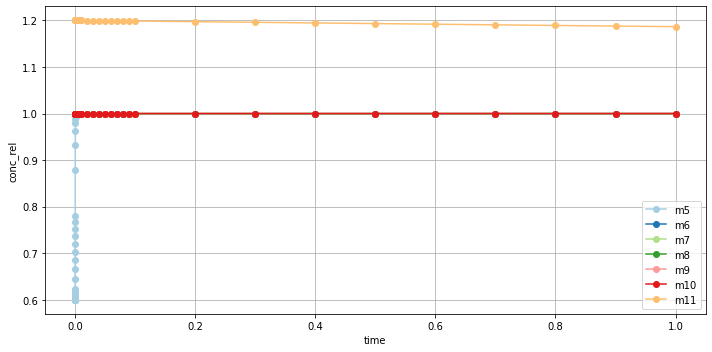

In [12]:
plot_model(conc, conc_interp, model_i=1, quant_type='conc_rel',
           selected_data=met_names,  x_scale='linear', y_scale='linear', x_lim=None,
            y_lim=None, fig_size=None, save_plot=False, output_file=None)

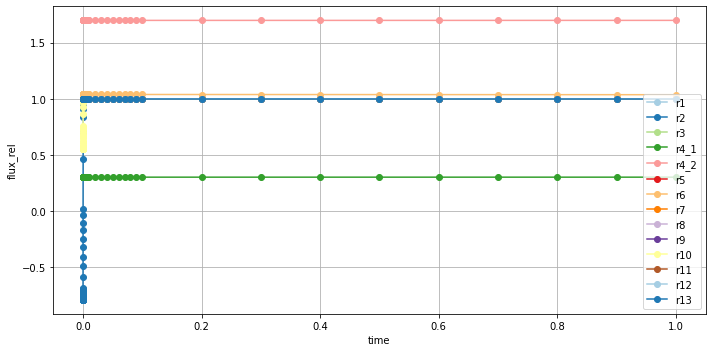

In [13]:
plot_model(flux, flux_interp, model_i=1, quant_type='flux_rel',
           selected_data=rxn_names,  x_scale='linear', y_scale='linear', x_lim=None,
            y_lim=None, fig_size=None, save_plot=False, output_file=None)

#### Plot summarized results for whole ensemble

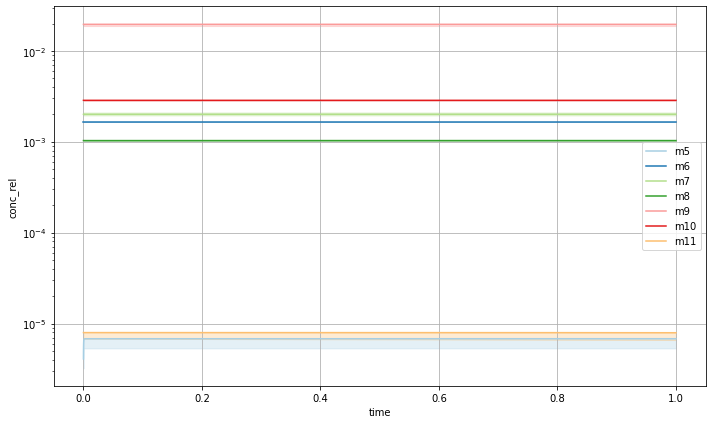

In [14]:
x_lim = None
y_lim = None

plot_ensemble(conc_interp_quantiles, quant_type='conc_rel', selected_data=[met_names], x_scale='linear',
              y_scale='log', x_lim=x_lim, y_lim=y_lim, fig_size=(10,6), save_plot=False, output_file=None)

/home/mrama/GRASP_test/GRASP/visualization/simulation_viz/simulation_viz/visualize_simulations.py:70: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.set_yscale(y_scale)


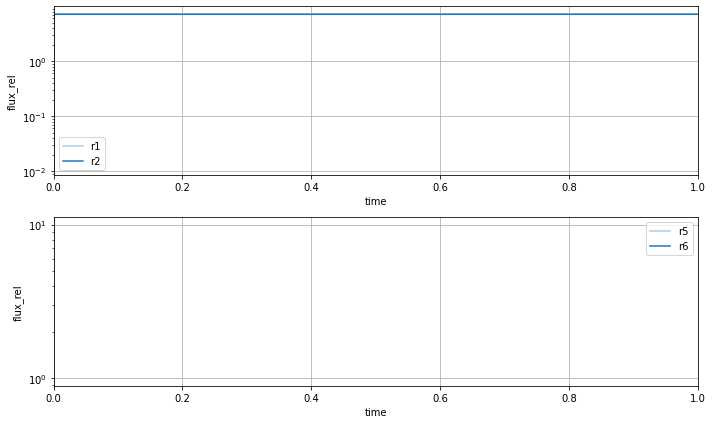

In [15]:
x_lim = [0, 1]
y_lim = None

plot_ensemble(flux_interp_quantiles, quant_type='flux_rel', selected_data=[['r1', 'r2'], ['r5', 'r6']], x_scale='linear',
              y_scale='log', x_lim=x_lim, y_lim=y_lim, fig_size=(10,6), save_plot=False, output_file=None)

### Plot results with altair

To plot absolute concentrations set quant_type='conc_abs', to plot relative concentrations set quant_type='conc_rel'.

To plot absolute fluxes set quant_type='flux_abs', to plot relative fluxes set quant_type='flux_rel'.

#### Plot results for a given model

In [16]:
plot_model_interactive(conc, conc_interp, model_i=2, quant_type='conc_abs',
                       selected_data=met_names, x_scale='linear',
                       y_scale='log', x_lim=[0,1], y_lim=None)

alt.Chart(...)

In [17]:
plot_model_interactive(flux, flux_interp, model_i=2, quant_type='flux_abs',
                       selected_data=rxn_names, x_scale='linear',
                       y_scale='linear', x_lim=[0,1], y_lim=None)

alt.Chart(...)

#### Plot summarized results for whole ensemble

In [18]:
plot_ensemble_interactive(conc_interp_quantiles, quant_type='conc_abs', selected_data=met_names, x_scale='linear',
                          y_scale='log', x_lim=None, y_lim=None)

alt.LayerChart(...)

In [19]:
plot_ensemble_interactive(flux_interp_quantiles, quant_type='flux_abs', selected_data=rxn_names, x_scale='linear',
                          y_scale='linear', x_lim=None, y_lim=None)

alt.LayerChart(...)